In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import optuna
import pickle
import plotly.express as px

from collections import Counter
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.inspection import permutation_importance
from lightgbm import LGBMRegressor

import sys
import os

RAND = 10
N_FOLDS = 3
TIMEOUT = 1200 #10800
N_TRIALS = 3000

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
model_path = os.path.abspath('../models')
sys.path.append(model_path)
from get_metrics import get_metrics_regression
from check_overfitting import check_overfitting

C:\Users\myxa-\AppData\Local\Temp\ipykernel_4948\2500531345.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Import data

In [2]:
# Чтение DataFrame df в файл data/df.csv
df = pd.read_csv('../data/df.csv')

In [3]:
df[:3]

milliseconds                               place    status  tsunami  \
0  1679500605010                          Washington  reviewed        0   
1  1679500834663  86 km WSW of El Aguilar, Argentina  reviewed        0   
2  1679501093539        39 km NNE of Chenega, Alaska  reviewed        0   

   significance   data_type  magnitude    country   longitude   latitude  \
0             1  earthquake       0.25        USA -121.940833  46.815333   
1           641  earthquake       6.40  Argentina  -66.495400 -23.422400   
2            44  earthquake       1.70        USA -147.822100  60.411700   

    depth             datetime timezone magnitude_bins  year  month  day  \
0    8.65  2023-03-22 15:56:45   +00:00          green  2023      3   22   
1  228.00  2023-03-22 16:00:34   +00:00            red  2023      3   22   
2   10.10  2023-03-22 16:04:53   +00:00          green  2023      3   22   

   hour  minute  second  
0    15      56      45  
1    16       0      34  
2    16       4      53

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46699 entries, 0 to 46698
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   milliseconds    46699 non-null  int64  
 1   place           46699 non-null  object 
 2   status          46699 non-null  object 
 3   tsunami         46699 non-null  int64  
 4   significance    46699 non-null  int64  
 5   data_type       46699 non-null  object 
 6   magnitude       46699 non-null  float64
 7   country         46699 non-null  object 
 8   longitude       46699 non-null  float64
 9   latitude        46699 non-null  float64
 10  depth           46699 non-null  float64
 11  datetime        46699 non-null  object 
 12  timezone        46699 non-null  object 
 13  magnitude_bins  46699 non-null  object 
 14  year            46699 non-null  int64  
 15  month           46699 non-null  int64  
 16  day             46699 non-null  int64  
 17  hour            46699 non-null 

In [5]:
# основные описательные статистики для числовых признаков
df.iloc[:, 1:].describe()

tsunami  significance     magnitude     longitude      latitude  \
count  46699.000000  46699.000000  46699.000000  46699.000000  46699.000000   
mean       0.000835     63.860532      1.663338   -116.184662     41.477024   
std        0.028887     92.829608      1.164436     71.863359     20.118682   
min        0.000000      0.000000      0.000000   -179.998700    -65.210500   
25%        0.000000     12.000000      0.900000   -153.251950     34.001167   
50%        0.000000     30.000000      1.390000   -122.819667     38.899900   
75%        0.000000     63.000000      2.030000   -116.585500     58.237767   
max        1.000000   1072.000000      7.700000    179.999400     86.593900   

              depth     year         month           day          hour  \
count  46699.000000  46699.0  46699.000000  46699.000000  46699.000000   
mean      26.301094   2023.0      5.241718     15.955481     11.544080   
std       55.148630      0.0      1.239712      8.752367      6.896567   
min       -3.440000   2023.0      3.000000      1.000000      0.000000   
25%        3.200000   2023.0      4.000000      8.000000      6.000000   
50%        9.000000   2023.0      5.000000     16.000000     12.000000   
75%       25.300000   2023.0      6.000000     24.000000     18.000000   
max      681.238000   2023.0      7.000000     30.000000     23.000000   

             minute        second  
count  46699.000000  46699.000000  
mean      29.355661     29.471359  
std       17.370932     17.299778  
min        0.000000      0.000000  
25%       14.000000     15.000000  
50%       29.000000     30.000000  
75%       44.000000     44.000000  
max       59.000000     59.000000

In [6]:
# основные описательные статистики для булевых и категориальных признаков
df.describe(include=["object", "bool"])

place    status   data_type country  \
count                       46699     46699       46699   46699   
unique                      20188         2           7     195   
top     7km NW of The Geysers, CA  reviewed  earthquake     USA   
freq                          499     41598       45509   40091   

                   datetime timezone magnitude_bins  
count                 46699    46699          46699  
unique                46603        1              3  
top     2023-04-16 17:25:07   +00:00          green  
freq                      2    46699          41074

# LabelEncoder

In [7]:
# создаем LabelEncoder для кодирования категориальных значений
le = LabelEncoder()

# список категориальных столбцов
categorical_cols = df.select_dtypes(include=[object]).columns

# кодируем каждый категориальный столбец
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

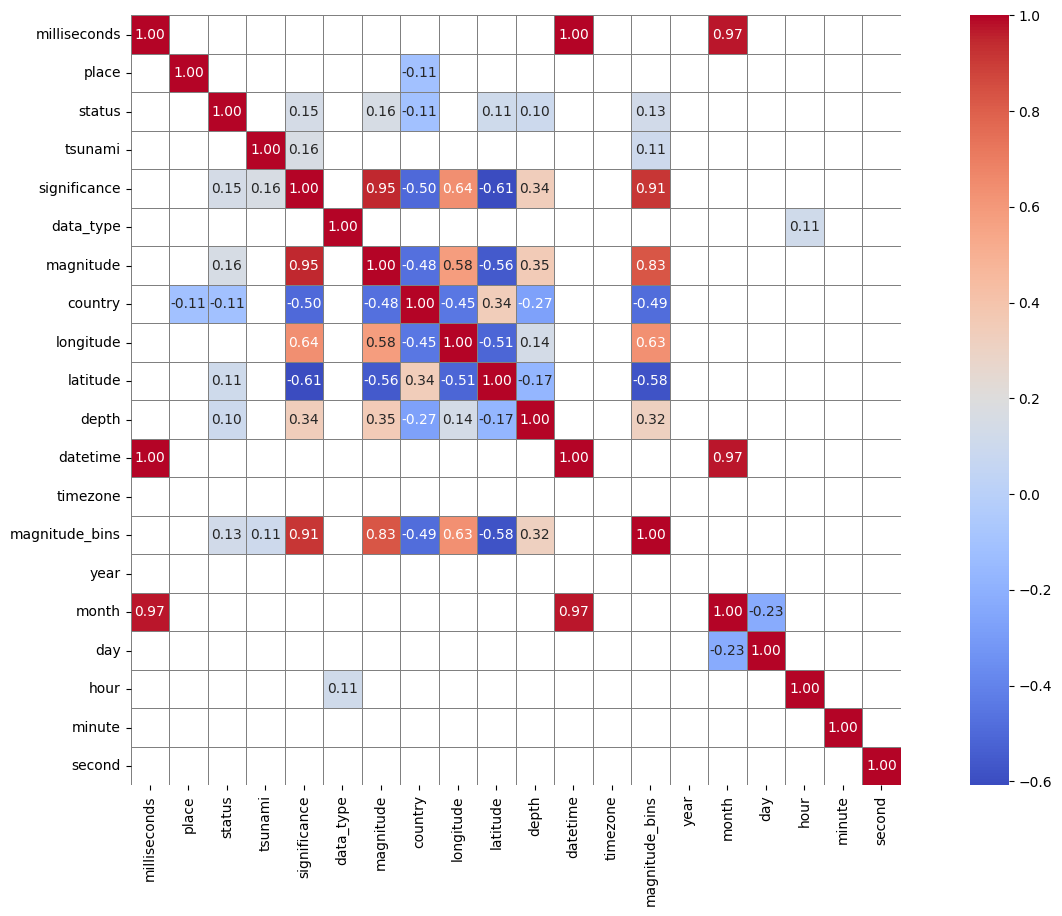

In [8]:
# рассчитываем матрицу корреляции
corr_matrix = df.corr()

# создаем маску
mask = np.abs(corr_matrix) < 0.1

# указывает размер графика
plt.figure(figsize=(18, 10))

# создаем тепловую карту матрицы корреляции
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, fmt='.2f', mask=mask, linewidths=0.5, linecolor='grey')

# Показываем график
plt.show()

In [9]:
df.columns

Index(['milliseconds', 'place', 'status', 'tsunami', 'significance',
       'data_type', 'magnitude', 'country', 'longitude', 'latitude', 'depth',
       'datetime', 'timezone', 'magnitude_bins', 'year', 'month', 'day',
       'hour', 'minute', 'second'],
      dtype='object')

# permutation_importance

In [10]:
# признаки
X = df[['milliseconds', 'place', 'status', 'tsunami', 'significance', 'data_type', 'country', 'depth',
        'datetime', 'timezone', 'magnitude_bins', 'year', 'month', 'day', 'hour', 'minute', 'second',
        # 'magnitude',
        # 'longitude',
        # 'latitude'
        ]]

# целевые переменные
y = df[[
    'magnitude',
    'longitude',
    'latitude'
    ]]

In [11]:
def train_permutation_importance(models, X, y, RAND):
    common_features_file = '../data/common_features.pkl'
    if os.path.exists(common_features_file):
        print("Используем предвычисленные общие признаки из", common_features_file)
        with open(common_features_file, 'rb') as f:
            common_features = pickle.load(f)
        return common_features
    else:
        print("Вычисляем важность признаков с помощью permutation importance...")
        important_features_models = []
        for model in models:
            importances_result = permutation_importance(model, X, y, n_repeats=3, random_state=RAND)
            importances = importances_result.importances_mean
            
            # сортируем признаки по важности
            sorted_importances = sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True)
            
            # выводим важность признаков для каждой модели
            print(f"Модель {model}:")
            important_features_model = [feature for feature, importance in sorted_importances if importance >= 0.05]
            print(important_features_model)
            print()
            
            important_features_models.append(important_features_model)
        
        # находим общие признаки в каждой модели
        feature_counts = Counter(feature for model_features in important_features_models for feature in model_features)
        common_features = [feature for feature, count in feature_counts.items() if count == len(important_features_models)]
        
        with open(common_features_file, 'wb') as f:
            pickle.dump(common_features, f)
        
        print("Общие важные признаки для моделей:")
        print(common_features)
        return common_features

In [12]:
# создаем список моделей
models = [
    RandomForestRegressor(random_state=RAND),
    MultiOutputRegressor(GradientBoostingRegressor(random_state=RAND)),
    DecisionTreeRegressor(random_state=RAND),
    MultiOutputRegressor(LGBMRegressor(random_state=RAND, verbosity=-1)),
]

# тренируем модели на всей выборке для определения важных признаков при помощи permutation_importance
for model in models:
    model.fit(X, y)

In [13]:
# вызываем функцию train_permutation_importance
common_features = train_permutation_importance(models, X, y, RAND)

Вычисляем важность признаков с помощью permutation importance...
Модель RandomForestRegressor(random_state=10):
['significance', 'country', 'place', 'depth']

Модель MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=10)):
['significance', 'country', 'place', 'depth']

Модель DecisionTreeRegressor(random_state=10):
['significance', 'country', 'place', 'depth', 'milliseconds']

Модель MultiOutputRegressor(estimator=LGBMRegressor(random_state=10, verbosity=-1)):
['significance', 'country', 'place', 'depth']

Общие важные признаки для моделей:
['significance', 'country', 'place', 'depth']


# разделение данных train_test_split

In [14]:
# признаки из permutation_importance
X = df[list(common_features)]

# целевые переменные
y = df[['magnitude', 'longitude', 'latitude']]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=RAND)

# Baseline 

## RandomForestRegressor

In [15]:
# модель RandomForestRegressor
rfr = RandomForestRegressor(random_state=RAND)
# обучаем модель
rfr.fit(X_train, y_train)
#  предсказания на тестовой выборке
y_pred_rfr = rfr.predict(X_test)

In [16]:
# проверка на переобучение модели RandomForestRegressor
check_overfitting(rfr, X_train, y_train, X_test, y_test, mean_squared_error)

mean_squared_error train: 21.934
mean_squared_error test: 189.476
delta = 88.4 %


In [17]:
# просмотр метрик модели RandomForestRegressor обученной на train
metrics = get_metrics_regression(y_test,
                                 y_pred = y_pred_rfr,
                                 X_test = X_test,
                                 name='RandomForestRegressor_Baseline')
metrics

model       MAE         MSE       RMSE  \
0  RandomForestRegressor_Baseline  3.716599  189.475852  13.765023   

   R2 adjusted  
0     0.925372

## DecisionTreeRegressor

In [18]:
# модель DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=RAND)
# обучаем модель
dtr.fit(X_train, y_train)
#  предсказания на тестовой выборке
y_pred_dtr = dtr.predict(X_test)

In [19]:
# проверка на переобучение модели DecisionTreeRegressor
check_overfitting(dtr, X_train, y_train, X_test, y_test, mean_squared_error)

mean_squared_error train: 0.062
mean_squared_error test: 295.563
delta = 100.0 %


In [20]:
# просмотр метрик модели DecisionTreeRegressor обученной на train
metrics = pd.concat([
    metrics,
    get_metrics_regression(y_test,
                           y_pred = y_pred_dtr,
                           X_test = X_test,
                           name='DecisionTreeRegressor_Baseline')])
metrics

model       MAE         MSE       RMSE  \
0  RandomForestRegressor_Baseline  3.716599  189.475852  13.765023   
0  DecisionTreeRegressor_Baseline  4.087706  295.562693  17.191937   

   R2 adjusted  
0     0.925372  
0     0.872147

## GradientBoostingRegressor

In [21]:
# модель GradientBoostingRegressor
gbr = MultiOutputRegressor(GradientBoostingRegressor(random_state=RAND))

# обучаем модель
gbr.fit(X_train, y_train)
#  предсказания на тестовой выборке
y_pred_gbr = gbr.predict(X_test)

In [22]:
# проверка на переобучение модели GradientBoostingRegressor
check_overfitting(gbr, X_train, y_train, X_test, y_test, mean_squared_error)

mean_squared_error train: 340.317
mean_squared_error test: 372.332
delta = 8.6 %


In [23]:
# просмотр метрик модели GradientBoostingRegressor обученной на train
metrics = pd.concat([
    metrics,
    get_metrics_regression(y_test,
                           y_pred = y_pred_gbr,
                           X_test = X_test,
                           name='GradientBoostingRegressor_Baseline')])
metrics

model       MAE         MSE       RMSE  \
0      RandomForestRegressor_Baseline  3.716599  189.475852  13.765023   
0      DecisionTreeRegressor_Baseline  4.087706  295.562693  17.191937   
0  GradientBoostingRegressor_Baseline  8.294159  372.332147  19.295910   

   R2 adjusted  
0     0.925372  
0     0.872147  
0     0.840329

## LightGBMRegressor

In [24]:
# модель LightGBMRegressor
lgbmreg = MultiOutputRegressor(LGBMRegressor(random_state=RAND, verbosity=-1))

# обучаем модель
lgbmreg.fit(X_train, y_train)

# предсказания на тестовой выборке
y_pred_lgbmreg = lgbmreg.predict(X_test)

In [25]:
# проверка на переобучение модели LightGBMRegressor
check_overfitting(lgbmreg, X_train, y_train, X_test, y_test, mean_squared_error)

mean_squared_error train: 174.261
mean_squared_error test: 239.602
delta = 27.3 %


In [26]:
# просмотр метрик модели GradientBoostingRegressor обученной на train
metrics = pd.concat([
    metrics,
    get_metrics_regression(y_test,
                           y_pred = y_pred_lgbmreg,
                           X_test = X_test,
                           name='LightGBMRegressor_Baseline')])
metrics

model       MAE         MSE       RMSE  \
0      RandomForestRegressor_Baseline  3.716599  189.475852  13.765023   
0      DecisionTreeRegressor_Baseline  4.087706  295.562693  17.191937   
0  GradientBoostingRegressor_Baseline  8.294159  372.332147  19.295910   
0          LightGBMRegressor_Baseline  5.570144  239.601800  15.479076   

   R2 adjusted  
0     0.925372  
0     0.872147  
0     0.840329  
0     0.904305

# Optuna & KFold подбор гиперпараметров и кросс-валидация

## RandomForestRegressor

In [27]:
# целевая функция для оптимизации
def objective(trial):
    global best_score
    # гиперпараметры для настройки
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 3)
    ccp_alpha = trial.suggest_float('ccp_alpha', 0.01, 1)
    min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5)
    max_features = trial.suggest_int('max_features', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    # RandomForestRegressor с гиперпараметрами
    rfr = RandomForestRegressor(n_estimators=n_estimators,
                                max_depth=max_depth,
                                min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf,
                                ccp_alpha = ccp_alpha,
                                min_weight_fraction_leaf=min_weight_fraction_leaf,
                                max_features=max_features,
                                bootstrap=bootstrap,
                                random_state=RAND)

    # выполнение кросс-валидации
    scores = cross_val_score(rfr, X_train, y_train, cv=KFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND))
    score = np.mean(scores)

        # добавляем условие для обрезки
    if score > best_score:
        best_score = score

    if score < best_score * 0.99: # обрезаем, если score меньше 99% от лучшего score
        raise optuna.TrialPruned()

    return -score  # Optuna минимизирует целевую функцию, поэтому использую -score

# проверка наличия сохраненной модели
best_params_file = os.path.join(model_path, 'rfr_best_params.pkl')
if os.path.exists(best_params_file):
    print('Модель уже сохранена.')
    with open(best_params_file, 'rb') as f:
        rfr_best_params = pickle.load(f)
    print('Параметры модели:', rfr_best_params.get_params())
else:
    print('Модель не сохранена, выполняем поиск гиперпараметров')
    # выполнение настройки гиперпараметров с Optuna
    study = optuna.create_study(direction='minimize')
    best_score = float('-inf')
    study.optimize(objective, n_trials=N_TRIALS, timeout=TIMEOUT)
    best_params = study.best_params
    # сохранение модели
    rfr_best_params = RandomForestRegressor(**best_params, random_state=RAND)
    with open(best_params_file, 'wb') as f:
        pickle.dump(rfr_best_params, f)
    print('Модель сохранена')
    print('Параметры модели:', rfr_best_params.get_params())

[I 2024-08-03 02:27:47,006] A new study created in memory with name: no-name-244534f9-8b60-4778-b789-c6e4b9c6b00f


Модель не сохранена, выполняем поиск гиперпараметров


[I 2024-08-03 02:27:57,681] Trial 0 finished with value: -0.2986411294007562 and parameters: {'n_estimators': 768, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 3, 'ccp_alpha': 0.2904686278053052, 'min_weight_fraction_leaf': 0.16716561793271095, 'max_features': 1, 'bootstrap': False}. Best is trial 0 with value: -0.2986411294007562.
[I 2024-08-03 02:28:02,087] Trial 1 pruned. 
[I 2024-08-03 02:28:33,592] Trial 2 finished with value: -0.7154762504887916 and parameters: {'n_estimators': 377, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 1, 'ccp_alpha': 0.5215785119116415, 'min_weight_fraction_leaf': 0.008108463783117026, 'max_features': 6, 'bootstrap': True}. Best is trial 2 with value: -0.7154762504887916.
[I 2024-08-03 02:28:40,986] Trial 3 pruned. 
[I 2024-08-03 02:29:06,129] Trial 4 pruned. 
[I 2024-08-03 02:29:51,529] Trial 5 pruned. 
[I 2024-08-03 02:29:53,730] Trial 6 pruned. 
[I 2024-08-03 02:30:28,556] Trial 7 pruned. 
[I 2024-08-03 02:30:37,155] Tria

Модель сохранена
Параметры модели: {'bootstrap': True, 'ccp_alpha': 0.8861392632423104, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 7, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.00027950713808381025, 'monotonic_cst': None, 'n_estimators': 246, 'n_jobs': None, 'oob_score': False, 'random_state': 10, 'verbose': 0, 'warm_start': False}


In [28]:
# обучение модели
rfr_best_params.fit(X_train, y_train)

# предсказания на тестовой выборке
y_pred_rfr_best_params = rfr_best_params.predict(X_test)

In [29]:
# оценка модели
check_overfitting(rfr_best_params, X_train, y_train, X_test, y_test, mean_squared_error)

# получение метрик
metrics = pd.concat([
    metrics,
    get_metrics_regression(y_test,
                           y_pred=y_pred_rfr_best_params,
                           X_test=X_test,
                           name='RandomForestRegressor_best_params_optuna')])
metrics

mean_squared_error train: 232.680
mean_squared_error test: 292.499
delta = 20.5 %


model       MAE         MSE       RMSE  \
0            RandomForestRegressor_Baseline  3.716599  189.475852  13.765023   
0            DecisionTreeRegressor_Baseline  4.087706  295.562693  17.191937   
0        GradientBoostingRegressor_Baseline  8.294159  372.332147  19.295910   
0                LightGBMRegressor_Baseline  5.570144  239.601800  15.479076   
0  RandomForestRegressor_best_params_optuna  6.809842  292.499135  17.102606   

   R2 adjusted  
0     0.925372  
0     0.872147  
0     0.840329  
0     0.904305  
0     0.792489

## DecisionTreeRegressor

In [30]:
# целевая функция для оптимизации
def objective(trial):
    global best_score
    # гиперпараметры для настройки
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 5, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 3)
    ccp_alpha = trial.suggest_float('ccp_alpha', 0.01, 1)
    min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5)
    max_features = trial.suggest_int('max_features', 1, 10)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 5)

    # DecisionTreeRegressor с гиперпараметрами
    rfr = DecisionTreeRegressor(
                                splitter=splitter,
                                max_depth=max_depth,
                                min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf,
                                ccp_alpha = ccp_alpha,
                                min_weight_fraction_leaf=min_weight_fraction_leaf,
                                max_features=max_features,
                                max_leaf_nodes=max_leaf_nodes,
                                random_state=RAND)

    # выполнение кросс-валидации
    scores = cross_val_score(rfr, X_train, y_train, cv=KFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND))
    score = np.mean(scores)

    # добавляем условие для обрезки
    if score > best_score:
        best_score = score

    if score < best_score * 0.99: # обрезаем, если score меньше 99% от лучшего score
        raise optuna.TrialPruned()

    return -score  # Optuna минимизирует целевую функцию, поэтому использую -score

# проверка наличия сохраненной модели
best_params_file = os.path.join(model_path, 'dtr_best_params.pkl')
if os.path.exists(best_params_file):
    print('Модель уже сохранена.')
    with open(best_params_file, 'rb') as f:
        dtr_best_params = pickle.load(f)
    print('Параметры модели:', dtr_best_params.get_params())
else:
    print('Модель не сохранена, выполняем поиск гиперпараметров')
    # выполнение настройки гиперпараметров с Optuna
    study = optuna.create_study(direction='minimize')
    best_score = float('-inf')
    study.optimize(objective, n_trials=N_TRIALS, timeout=TIMEOUT)
    best_params = study.best_params
    # сохранение модели
    dtr_best_params = DecisionTreeRegressor(**best_params, random_state=RAND)
    with open(best_params_file, 'wb') as f:
        pickle.dump(dtr_best_params, f)
    print('Модель сохранена')
    print('Параметры модели:', dtr_best_params.get_params())

[I 2024-08-03 02:48:07,600] A new study created in memory with name: no-name-17aa44e8-746d-4890-90d7-dfbcfd37ec16
[I 2024-08-03 02:48:07,632] Trial 0 pruned. 
[I 2024-08-03 02:48:07,661] Trial 1 pruned. 
[I 2024-08-03 02:48:07,707] Trial 2 finished with value: -0.2964179671578344 and parameters: {'splitter': 'best', 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1, 'ccp_alpha': 0.9953129471542635, 'min_weight_fraction_leaf': 0.34558658513821006, 'max_features': 3, 'max_leaf_nodes': 5}. Best is trial 2 with value: -0.2964179671578344.
[I 2024-08-03 02:48:07,737] Trial 3 pruned. 
[I 2024-08-03 02:48:07,765] Trial 4 pruned. 


Модель не сохранена, выполняем поиск гиперпараметров


[I 2024-08-03 02:48:07,795] Trial 5 pruned. 
[I 2024-08-03 02:48:07,831] Trial 6 finished with value: -0.4672237587899916 and parameters: {'splitter': 'random', 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 3, 'ccp_alpha': 0.7708636943618611, 'min_weight_fraction_leaf': 0.013125204095991161, 'max_features': 7, 'max_leaf_nodes': 4}. Best is trial 6 with value: -0.4672237587899916.
[I 2024-08-03 02:48:07,860] Trial 7 pruned. 
[I 2024-08-03 02:48:07,895] Trial 8 pruned. 
[I 2024-08-03 02:48:07,944] Trial 9 pruned. 
[I 2024-08-03 02:48:08,024] Trial 10 finished with value: -0.511362549168554 and parameters: {'splitter': 'best', 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 3, 'ccp_alpha': 0.7685919240304833, 'min_weight_fraction_leaf': 0.022157635338660296, 'max_features': 1, 'max_leaf_nodes': 5}. Best is trial 10 with value: -0.511362549168554.
[I 2024-08-03 02:48:08,104] Trial 11 pruned. 
[I 2024-08-03 02:48:08,217] Trial 12 finished with value: -0.52364238450

Модель сохранена
Параметры модели: {'ccp_alpha': 0.581277504189259, 'criterion': 'squared_error', 'max_depth': 6, 'max_features': 10, 'max_leaf_nodes': 5, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 9, 'min_weight_fraction_leaf': 0.023795432625895105, 'monotonic_cst': None, 'random_state': 10, 'splitter': 'random'}


In [31]:
# обучение модели
dtr_best_params.fit(X_train, y_train)

# предсказания на тестовой выборке
y_pred_dtr_best_params = dtr_best_params.predict(X_test)

In [32]:
# оценка модели
check_overfitting(dtr_best_params, X_train, y_train, X_test, y_test, mean_squared_error)

# получение метрик
metrics = pd.concat([
    metrics,
    get_metrics_regression(y_test,
                           y_pred=y_pred_dtr_best_params,
                           X_test=X_test,
                           name='DecisionTreeRegressor_best_params_optuna')])
metrics

mean_squared_error train: 984.295
mean_squared_error test: 939.073
delta = 4.8 %


model        MAE         MSE       RMSE  \
0            RandomForestRegressor_Baseline   3.716599  189.475852  13.765023   
0            DecisionTreeRegressor_Baseline   4.087706  295.562693  17.191937   
0        GradientBoostingRegressor_Baseline   8.294159  372.332147  19.295910   
0                LightGBMRegressor_Baseline   5.570144  239.601800  15.479076   
0  RandomForestRegressor_best_params_optuna   6.809842  292.499135  17.102606   
0  DecisionTreeRegressor_best_params_optuna  14.928694  939.073179  30.644301   

   R2 adjusted  
0     0.925372  
0     0.872147  
0     0.840329  
0     0.904305  
0     0.792489  
0     0.584849

## GradientBoostingRegressor

In [33]:
# целевая функция для оптимизации
def objective(trial):
    global best_score
    # гиперпараметры для настройки
    learning_rate = trial.suggest_float('estimator__learning_rate', 0.1, 1)
    n_estimators = trial.suggest_int('estimator__n_estimators', 100, 1000)
    subsample = trial.suggest_float('estimator__subsample', 0.1, 1.0)
    min_samples_split = trial.suggest_int('estimator__min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('estimator__min_samples_leaf', 1, 5)
    alpha = trial.suggest_float('alpha', 0.01, 1)
    min_weight_fraction_leaf = trial.suggest_float('estimator__min_weight_fraction_leaf', 0.0, 0.5)
    max_depth = trial.suggest_int('estimator__max_depth', 1, 10)

    # GradientBoostingRegressor с гиперпараметрами
    gbr = MultiOutputRegressor(GradientBoostingRegressor(learning_rate=learning_rate,                                                    
                                                         n_estimators=n_estimators,
                                                         subsample=subsample,
                                                         min_samples_split=min_samples_split,
                                                         min_samples_leaf=min_samples_leaf,
                                                         alpha = alpha,
                                                         min_weight_fraction_leaf=min_weight_fraction_leaf,
                                                         max_depth=max_depth,
                                                         random_state=RAND))

    # выполнение кросс-валидации
    scores = cross_val_score(gbr, X_train, y_train, cv=KFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND))
    score = np.mean(scores)

        # добавляем условие для обрезки
    if score > best_score:
        best_score = score

    if score < best_score * 0.99: # обрезаем, если score меньше 99% от лучшего score
        raise optuna.TrialPruned()

    return -score  # Optuna минимизирует целевую функцию, поэтому использую -score

# проверка наличия сохраненной модели
best_params_file = os.path.join(model_path, 'gbr_best_params.pkl')
if os.path.exists(best_params_file):
    print('Модель уже сохранена.')
    with open(best_params_file, 'rb') as f:
        gbr_best_params = pickle.load(f)
    print('Параметры модели:', gbr_best_params.get_params())
else:
    print('Модель не сохранена, выполняем поиск гиперпараметров')
    # выполнение настройки гиперпараметров с Optuna
    study = optuna.create_study(direction='minimize')
    best_score = float('-inf')
    study.optimize(objective, n_trials=N_TRIALS, timeout=TIMEOUT)
    best_params = study.best_params
    # удалить префикс 'estimator__' из ключей
    best_params = {k.replace('estimator__', ''): v for k, v in best_params.items()}
    # сохранение модели
    gbr_best_params = MultiOutputRegressor(GradientBoostingRegressor(**best_params, random_state=RAND))
    with open(best_params_file, 'wb') as f:
        pickle.dump(gbr_best_params, f)
    print('Модель сохранена')
    print('Параметры модели:', gbr_best_params.get_params())

[I 2024-08-03 02:56:41,530] A new study created in memory with name: no-name-9d4ba065-59f3-47f7-972b-7d1f7ffb327d


Модель не сохранена, выполняем поиск гиперпараметров


[I 2024-08-03 02:57:47,343] Trial 0 finished with value: -0.4739500880510323 and parameters: {'estimator__learning_rate': 0.49356922064103537, 'estimator__n_estimators': 945, 'estimator__subsample': 0.997700365075691, 'estimator__min_samples_split': 9, 'estimator__min_samples_leaf': 1, 'alpha': 0.5128257009952356, 'estimator__min_weight_fraction_leaf': 0.25574624106228105, 'estimator__max_depth': 1}. Best is trial 0 with value: -0.4739500880510323.
[I 2024-08-03 02:58:16,832] Trial 1 pruned. 
[I 2024-08-03 02:58:43,583] Trial 2 finished with value: -0.603455701236938 and parameters: {'estimator__learning_rate': 0.46451585235869486, 'estimator__n_estimators': 283, 'estimator__subsample': 0.5687139943523573, 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 2, 'alpha': 0.7391153958426765, 'estimator__min_weight_fraction_leaf': 0.1815204830414036, 'estimator__max_depth': 10}. Best is trial 2 with value: -0.603455701236938.
[I 2024-08-03 02:58:53,368] Trial 3 pruned. 
[I 2

Модель сохранена
Параметры модели: {'estimator__alpha': 0.9724888960245012, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'friedman_mse', 'estimator__init': None, 'estimator__learning_rate': 0.13131836048400414, 'estimator__loss': 'squared_error', 'estimator__max_depth': 9, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 5, 'estimator__min_samples_split': 5, 'estimator__min_weight_fraction_leaf': 0.0005980419567387842, 'estimator__n_estimators': 491, 'estimator__n_iter_no_change': None, 'estimator__random_state': 10, 'estimator__subsample': 0.4353407187076541, 'estimator__tol': 0.0001, 'estimator__validation_fraction': 0.1, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': GradientBoostingRegressor(alpha=0.9724888960245012,
                          learning_rate=0.13131836048400414, max_depth=9,
                          min_samples_leaf=5, min_samples_split=5,
      

In [34]:
# обучение модели
gbr_best_params.fit(X_train, y_train)

# предсказания на тестовой выборке
y_pred_gbr_best_params = gbr_best_params.predict(X_test)

In [35]:
# оценка модели
check_overfitting(gbr_best_params, X_train, y_train, X_test, y_test, mean_squared_error)

# получение метрик
metrics = pd.concat([
    metrics,
    get_metrics_regression(y_test,
                           y_pred=y_pred_gbr_best_params,
                           X_test=X_test,
                           name='GradientBoostingRegressor_best_params_optuna')])
metrics

mean_squared_error train: 51.647
mean_squared_error test: 168.977
delta = 69.4 %


model        MAE         MSE  \
0                RandomForestRegressor_Baseline   3.716599  189.475852   
0                DecisionTreeRegressor_Baseline   4.087706  295.562693   
0            GradientBoostingRegressor_Baseline   8.294159  372.332147   
0                    LightGBMRegressor_Baseline   5.570144  239.601800   
0      RandomForestRegressor_best_params_optuna   6.809842  292.499135   
0      DecisionTreeRegressor_best_params_optuna  14.928694  939.073179   
0  GradientBoostingRegressor_best_params_optuna   4.159242  168.976591   

        RMSE  R2 adjusted  
0  13.765023     0.925372  
0  17.191937     0.872147  
0  19.295910     0.840329  
0  15.479076     0.904305  
0  17.102606     0.792489  
0  30.644301     0.584849  
0  12.999100     0.938899

## LightGBMRegressor

In [36]:
# целевая функция для оптимизации
def objective(trial):
    global best_score
    # гиперпараметры для настройки
    learning_rate = trial.suggest_float('estimator__learning_rate', 0.01, 1)
    n_estimators = trial.suggest_int('estimator__n_estimators', 100, 1000)
    num_leaves = trial.suggest_int('estimator__num_leaves', 31, 255)
    subsample = trial.suggest_float('estimator__subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_float('estimator__colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_float('estimator__reg_alpha', 0.01, 1)
    reg_lambda = trial.suggest_float('estimator__reg_lambda', 0.01, 1)

    # LGBMRegressor с гиперпараметрами
    lgbm = MultiOutputRegressor(LGBMRegressor(learning_rate=learning_rate, 
                                               n_estimators=n_estimators, 
                                               num_leaves=num_leaves, 
                                               subsample=subsample, 
                                               colsample_bytree=colsample_bytree, 
                                               reg_alpha=reg_alpha, 
                                               reg_lambda=reg_lambda, 
                                               random_state=RAND))

    # выполнение кросс-валидации
    scores = cross_val_score(lgbmreg, X_train, y_train, cv=KFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND))
    score = np.mean(scores)

    # добавляем условие для обрезки
    if score > best_score:
        best_score = score

    if score < best_score * 0.99: # обрезаем, если score меньше 99% от лучшего score
        raise optuna.TrialPruned()

    return -score  # Optuna минимизирует целевую функцию, поэтому использую -score

# проверка наличия сохраненной модели
best_params_file = os.path.join(model_path, 'lgbmreg_best_params.pkl')
if os.path.exists(best_params_file):
    print('Модель уже сохранена.')
    with open(best_params_file, 'rb') as f:
        lgbmreg_best_params = pickle.load(f)
    print('Параметры модели:', lgbmreg_best_params.get_params())
else:
    print('Модель не сохранена, выполняем поиск гиперпараметров')
    # выполнение настройки гиперпараметров с Optuna
    study = optuna.create_study(direction='minimize')
    best_score = float('-inf')
    study.optimize(objective, n_trials=N_TRIALS, timeout=TIMEOUT)
    best_params = study.best_params
    # удалить префикс 'estimator__' из ключей
    best_params = {k.replace('estimator__', ''): v for k, v in best_params.items()}
    # сохранение модели
    lgbmreg_best_params = MultiOutputRegressor(LGBMRegressor(**best_params, random_state=RAND))
    with open(best_params_file, 'wb') as f:
        pickle.dump(lgbmreg_best_params, f)
    print('Модель сохранена')
    print('Параметры модели:', lgbmreg_best_params.get_params())

[I 2024-08-03 03:17:51,547] A new study created in memory with name: no-name-13ccd739-31bf-4708-87ea-f344ec35d591


Модель не сохранена, выполняем поиск гиперпараметров


[I 2024-08-03 03:17:52,592] Trial 0 finished with value: -0.9120751515419528 and parameters: {'estimator__learning_rate': 0.2419683638984402, 'estimator__n_estimators': 427, 'estimator__num_leaves': 253, 'estimator__subsample': 0.7482856314962784, 'estimator__colsample_bytree': 0.1591115179988139, 'estimator__reg_alpha': 0.24885412776718824, 'estimator__reg_lambda': 0.7654297935889671}. Best is trial 0 with value: -0.9120751515419528.
[I 2024-08-03 03:17:53,537] Trial 1 finished with value: -0.9120751515419528 and parameters: {'estimator__learning_rate': 0.24324975354461711, 'estimator__n_estimators': 469, 'estimator__num_leaves': 41, 'estimator__subsample': 0.5695811151359945, 'estimator__colsample_bytree': 0.8404612171791513, 'estimator__reg_alpha': 0.04800044662995812, 'estimator__reg_lambda': 0.3568048519421359}. Best is trial 0 with value: -0.9120751515419528.
[I 2024-08-03 03:17:54,488] Trial 2 finished with value: -0.9120751515419528 and parameters: {'estimator__learning_rate': 

Модель сохранена
Параметры модели: {'estimator__boosting_type': 'gbdt', 'estimator__class_weight': None, 'estimator__colsample_bytree': 0.1591115179988139, 'estimator__importance_type': 'split', 'estimator__learning_rate': 0.2419683638984402, 'estimator__max_depth': -1, 'estimator__min_child_samples': 20, 'estimator__min_child_weight': 0.001, 'estimator__min_split_gain': 0.0, 'estimator__n_estimators': 427, 'estimator__n_jobs': None, 'estimator__num_leaves': 253, 'estimator__objective': None, 'estimator__random_state': 10, 'estimator__reg_alpha': 0.24885412776718824, 'estimator__reg_lambda': 0.7654297935889671, 'estimator__subsample': 0.7482856314962784, 'estimator__subsample_for_bin': 200000, 'estimator__subsample_freq': 0, 'estimator': LGBMRegressor(colsample_bytree=0.1591115179988139,
              learning_rate=0.2419683638984402, n_estimators=427,
              num_leaves=253, random_state=10, reg_alpha=0.24885412776718824,
              reg_lambda=0.7654297935889671, subsample=0.

In [37]:
# обучение модели
lgbmreg_best_params.fit(X_train, y_train)

# предсказания на тестовой выборке
y_pred_lgbmreg_best_params = lgbmreg_best_params.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train set: 37359, number of used features: 4
[LightGBM] [Info] Start training from score 1.664722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [38]:
# оценка модели
check_overfitting(lgbmreg_best_params, X_train, y_train, X_test, y_test, mean_squared_error)

# получение метрик
metrics = pd.concat([
    metrics,
    get_metrics_regression(y_test,
                           y_pred=y_pred_lgbmreg_best_params,
                           X_test=X_test,
                           name='LightGBMRegressor_best_params_optuna')])
metrics

# сохранение metrics в файл data/metrics.csv
metrics.to_csv('../data/metrics.csv', index=False)

mean_squared_error train: 222.348
mean_squared_error test: 256.638
delta = 13.4 %


# Функция выбора лучшей модели

In [39]:
def select_best_model(X_test, y_test,
                      rfr_best_params,
                      dtr_best_params,
                      gbr_best_params,
                      lgbmreg_best_params
                      ):
    """
    Выбирает лучшую модель на основе средней квадратичной ошибки (MSE) на тестовой выборке.

    Параметры:
    - X_test: Тестовые признаки
    - y_test: Тестовая целевая переменная
    - rfr_best_params: Обученная модель случайного леса регрессии
    - dtr_best_params: Обученная модель дерева решений регрессии
    - gbr_best_params: Обученная модель градиентного бустинга регрессии
    - lgbmreg_best_params: Обученная модель LightGBM регрессии

    Возвращает:
    - Лучшую модель на основе MSE
    """
    models = [rfr_best_params,
              dtr_best_params,
              gbr_best_params,
              lgbmreg_best_params,
              ]
    mse_values = []

    for model in models:
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_values.append(mse)

    best_model_index = mse_values.index(min(mse_values))
    best_model = models[best_model_index]

    return best_model

In [40]:
# используем функцию выбора лучшей модели
best_model = select_best_model(X_test, y_test,
                               rfr_best_params,
                               dtr_best_params,
                               gbr_best_params,
                               lgbmreg_best_params,
                               )
print("Лучшая модель:", best_model)

Лучшая модель: MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9724888960245012,
                                                         learning_rate=0.13131836048400414,
                                                         max_depth=9,
                                                         min_samples_leaf=5,
                                                         min_samples_split=5,
                                                         min_weight_fraction_leaf=0.0005980419567387842,
                                                         n_estimators=491,
                                                         random_state=10,
                                                         subsample=0.4353407187076541))


In [41]:
# предсказания на тестовой выборке лучшей модели
y_pred_best_model = best_model.predict(X_test)

In [42]:
df_y_pred_rfr_best_params = pd.DataFrame(y_pred_rfr_best_params, columns=['magnitude', 'longitude', 'latitude'])
df_y_pred_dtr_best_params = pd.DataFrame(y_pred_dtr_best_params, columns=['magnitude', 'longitude', 'latitude'])
df_y_pred_gbr_best_params = pd.DataFrame(y_pred_gbr_best_params, columns=['magnitude', 'longitude', 'latitude'])
df_y_pred_lgbmreg_best_params = pd.DataFrame(y_pred_lgbmreg_best_params, columns=['magnitude', 'longitude', 'latitude'])
df_y_pred_best_model = pd.DataFrame(y_pred_best_model, columns=['magnitude', 'longitude', 'latitude'])

## Сравнение карт моделей и фактических данных

In [43]:
def create_earthquake_maps(y_test, y_pred_model, model_name):
    """
    Создает 2 карты с магнитудой реальными данными и данными из y_pred_model.
    
    Параметры:
    y_test (DataFrame): Реальные данные.
    y_pred_model (DataFrame): Предсказанные данные.
    model_name (str): Название модели.
    
    Возвращает:
    fig (Figure): "Две карты".
    """
    y_pred_model['model_name'] = model_name
    fig1 = px.scatter_geo(y_test, lat='latitude', lon='longitude', color='magnitude', color_continuous_scale='reds', title='Earthquakes Around the World best vs fact')
    fig2 = px.scatter_geo(y_pred_model, lat='latitude', lon='longitude', color='magnitude', color_continuous_scale='reds', title='Earthquakes Around the World')
    
    for fig in [fig1, fig2]:
        fig.update_layout(geo=dict(landcolor='white', oceancolor='lightblue', showland=True, showocean=True), width=600, height=400)
    
    fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'geo'}, {'type': 'geo'}]], subplot_titles=['Earthquakes Around the World fact', f'Earthquakes Around the World {model_name}'])
    fig.add_trace(fig1.data[0], row=1, col=1)
    fig.add_trace(fig2.data[0], row=1, col=2)
    fig.update_layout(width=1450, height=600)
    
    return fig

In [44]:
# Используем функцию отрисовки карты
model_name = best_model.estimator.__class__.__name__
fig = create_earthquake_maps(y_test, df_y_pred_best_model, model_name)
fig.show()

In [45]:
# Используем функцию отрисовки карты
model_name = rfr_best_params.__class__.__name__
fig = create_earthquake_maps(y_test, df_y_pred_rfr_best_params, model_name)
fig.show()

In [46]:
# Используем функцию отрисовки карты
model_name = dtr_best_params.__class__.__name__
fig = create_earthquake_maps(y_test, df_y_pred_dtr_best_params, model_name)
fig.show()

In [47]:
# Используем функцию отрисовки карты
model_name = gbr_best_params.estimator.__class__.__name__
fig = create_earthquake_maps(y_test, df_y_pred_gbr_best_params, model_name)
fig.show()

In [48]:
# Используем функцию отрисовки карты
model_name = lgbmreg_best_params.estimator.__class__.__name__
fig = create_earthquake_maps(y_test, df_y_pred_lgbmreg_best_params, model_name)
fig.show()

In [51]:
metrics

model        MAE         MSE  \
0                RandomForestRegressor_Baseline   3.716599  189.475852   
0                DecisionTreeRegressor_Baseline   4.087706  295.562693   
0            GradientBoostingRegressor_Baseline   8.294159  372.332147   
0                    LightGBMRegressor_Baseline   5.570144  239.601800   
0      RandomForestRegressor_best_params_optuna   6.809842  292.499135   
0      DecisionTreeRegressor_best_params_optuna  14.928694  939.073179   
0  GradientBoostingRegressor_best_params_optuna   4.159242  168.976591   
0          LightGBMRegressor_best_params_optuna   6.120860  256.637698   

        RMSE  R2 adjusted  
0  13.765023     0.925372  
0  17.191937     0.872147  
0  19.295910     0.840329  
0  15.479076     0.904305  
0  17.102606     0.792489  
0  30.644301     0.584849  
0  12.999100     0.938899  
0  16.019916     0.896530

In [49]:
# # Обратное преобразование масштабированных данных в X_train
# X_train[['milliseconds', 'depth', 'year', 'month', 'day', 'hour', 'minute', 'second']] = scaler.inverse_transform(X_train[['milliseconds', 'depth', 'year', 'month', 'day', 'hour', 'minute', 'second']])

# # Обратное преобразование масштабированных данных в X_test
# X_test[['milliseconds', 'depth', 'year', 'month', 'day', 'hour', 'minute', 'second']] = scaler.inverse_transform(X_test[['milliseconds', 'depth', 'year', 'month', 'day', 'hour', 'minute', 'second']])

In [50]:
# декодирование колонки 'country'
#X_train['country'] = le.inverse_transform(X_train['country'])
#X_test['country'] = le.inverse_transform(X_test['country'])